In [70]:
import torch

print(f"CUDA is available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"Current GPU: {torch.cuda.current_device()}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")

CUDA is available: True
CUDA version: 12.1
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 4060


In [71]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import sys

sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Loading Ray Dataset: 

## 1.1 Creating dataset objects:

In [72]:
from datasets import RayAlzheymerDataset

train_dataset = RayAlzheymerDataset('datasets/ray_dataset/AD-Train-120.csv')
test_dataset = RayAlzheymerDataset('datasets/ray_dataset/AD-Test-120.csv')

In [73]:
train_dataset

In [74]:
test_dataset

## 1.2 Creating Dataloader Objects:

In [75]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# 2 Constructing Model Architecture:

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2.1 MLP Model

In [77]:
from models import MLPModel
input_size = train_dataset[0][0].shape[0]
hidden_channels = 128
output_size = 1
model = MLPModel(input_size=input_size, hidden_channels=hidden_channels, output_size=output_size).to(device)

<string>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


## 2.2 Optimizer and Criterion:

In [78]:
import torch.nn as nn
import torch.optim.adam
criterion = nn.BCELoss()
learning_rate = .001
weight_decay = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 3 Training the Model:

In [79]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # Move inputs to GPU
        labels = labels.to(device)  # Move labels to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/100], Loss: 0.6325
Epoch [2/100], Loss: 0.6162
Epoch [3/100], Loss: 0.6181
Epoch [4/100], Loss: 0.5983
Epoch [5/100], Loss: 0.6086
Epoch [6/100], Loss: 0.5881
Epoch [7/100], Loss: 0.5826
Epoch [8/100], Loss: 0.5839
Epoch [9/100], Loss: 0.5842
Epoch [10/100], Loss: 0.5673
Epoch [11/100], Loss: 0.5657
Epoch [12/100], Loss: 0.5784
Epoch [13/100], Loss: 0.5692
Epoch [14/100], Loss: 0.5672
Epoch [15/100], Loss: 0.5531
Epoch [16/100], Loss: 0.5628
Epoch [17/100], Loss: 0.5480
Epoch [18/100], Loss: 0.5450
Epoch [19/100], Loss: 0.5399
Epoch [20/100], Loss: 0.5340
Epoch [21/100], Loss: 0.5436
Epoch [22/100], Loss: 0.5340
Epoch [23/100], Loss: 0.5388
Epoch [24/100], Loss: 0.5392
Epoch [25/100], Loss: 0.5309
Epoch [26/100], Loss: 0.5232
Epoch [27/100], Loss: 0.5290
Epoch [28/100], Loss: 0.5193
Epoch [29/100], Loss: 0.5101
Epoch [30/100], Loss: 0.5102
Epoch [31/100], Loss: 0.5026
Epoch [32/100], Loss: 0.5044
Epoch [33/100], Loss: 0.5025
Epoch [34/100], Loss: 0.4970
Epoch [35/100], Loss: 0

# 4 Evaluating the Model:

In [81]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(labels)
        print(predicted)

accuracy = 100 * correct / total
print(f"Accuracy on test data: {accuracy:.2f}%")

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')
Accuracy on test data: 95.06%


F1 Score: 0.6829


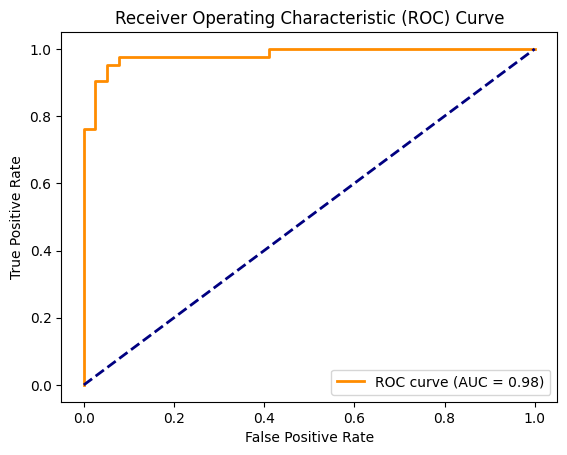

In [82]:
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import torch

model.eval()  
all_preds = []
all_labels = []
all_probs = []  # To store predicted probabilities

with torch.no_grad():  
    for inputs, labels in test_loader:  
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = (probs >= 0.5).float()  # Binary predictions
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Store probabilities

# Calculate F1 score
f1 = f1_score(all_labels, all_preds)
print(f"F1 Score: {f1:.4f}")

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)  # Use probabilities for ROC
roc_auc = auc(fpr, tpr)  # Calculate AUC

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()